# Pyro

In [1]:
use_cuda = False

In [2]:
# import pymc3 as pm
import numpy as np
import pandas as pd
# from theano import shared
import scipy.stats as stats
import matplotlib.pyplot as plt
import arviz as az

In [3]:
az.style.use('arviz-darkgrid')

In [4]:
import torch
if use_cuda and torch.cuda.is_available():
    print("PyTorch backend {}".format('gpu'))
    device = torch.device('cuda:0')
#     torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    use_cuda = False
    device = torch.device('cpu')
    print("PyTorch backend {}".format('cpu'))

PyTorch backend cpu


In [184]:
import logging
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.infer import MCMC, NUTS, Predictive, TracePredictive
from pyro.infer.mcmc.util import initialize_model, summary
from pyro import deterministic

logging.basicConfig(format='%(message)s', level=logging.INFO)
pyro.enable_validation(__debug__)
pyro.set_rng_seed(0)

## Simple linear regression

In [6]:
np.random.seed(1)
N = 100
alpha_real = 2.5
beta_real = 0.9
eps_real = np.random.normal(0, 0.5, size=N)

x = np.random.normal(10, 1, N)
y_real = alpha_real + beta_real * x
y = y_real + eps_real

# we can center the data
#x = x - x.mean()
# or standardize the data
#x = (x - x.mean())/x.std()
#y = (y - y.mean())/y.std()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  


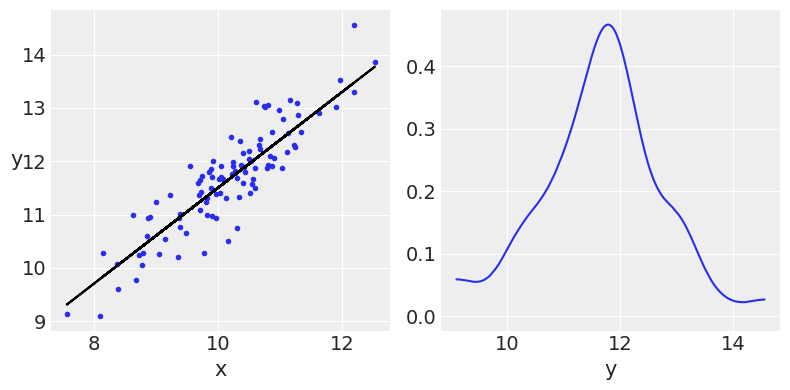

In [7]:
_, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(x, y, 'C0.')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y', rotation=0)
ax[0].plot(x, y_real, 'k')
az.plot_kde(y, ax=ax[1])
ax[1].set_xlabel('y')
plt.tight_layout()
plt.savefig('B11197_03_02.png', dpi=300)

In [8]:
def model_g(x, y=None):
    alpha = pyro.sample('alpha', dist.Normal(loc=0, scale=10)).to(device)
    beta = pyro.sample('beta', dist.Normal(loc=0, scale=1)).to(device)
    eps = pyro.sample('eps', dist.HalfCauchy(5.)).to(device)
    
    mu = alpha + beta * x
    
    # key issue: don't use y other than 'obs'
    if use_cuda:
        with pyro.plate("plate", size=x.shape[0], use_cuda=use_cuda):
            return pyro.sample("obs", dist.Normal(loc=mu, scale=eps), obs=y)
    else:
        with pyro.plate("plate", size=x.shape[0], use_cuda=None):
            return pyro.sample("obs", dist.Normal(loc=mu, scale=eps), obs=y)

In [9]:
x_tensor = torch.from_numpy(x).to(device)
y_tensor = torch.from_numpy(y).to(device)
x_tensor.shape, y_tensor.shape

(torch.Size([100]), torch.Size([100]))

### MCMC

In [10]:
%%time
pyro.clear_param_store() 

nuts_kernel = NUTS(model_g)
mcmc = MCMC(nuts_kernel, num_samples=2000, warmup_steps=1000, num_chains=1)
# mcmc = MCMC(nuts_kernel, num_samples=200, warmup_steps=50, num_chains=1)
mcmc.run(x_tensor, y_tensor)
posterior_samples = mcmc.get_samples()

Sample: 100%|██████████| 3000/3000 [05:52,  8.51it/s, step size=6.65e-02, acc. prob=0.928]

CPU times: user 4min 13s, sys: 742 ms, total: 4min 14s
Wall time: 5min 52s


In [11]:
mcmc.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      2.11      0.49      2.11      1.27      2.83    620.71      1.00
      beta      0.94      0.05      0.94      0.87      1.02    620.37      1.00
       eps      0.45      0.03      0.45      0.40      0.51    738.61      1.01

Number of divergences: 0


In [12]:
posterior_samples

{'alpha': tensor([2.0871, 2.4184, 2.2507,  ..., 2.9435, 2.0265, 2.4587],
        dtype=torch.float64),
 'beta': tensor([0.9404, 0.9144, 0.9259,  ..., 0.8650, 0.9483, 0.9074],
        dtype=torch.float64),
 'eps': tensor([0.4298, 0.4214, 0.4330,  ..., 0.4071, 0.4465, 0.4540],
        dtype=torch.float64)}

In [13]:
posterior_predictive = Predictive(model_g, posterior_samples)(x_tensor, None)
posterior_predictive

{'obs': tensor([[11.1616, 12.7404, 11.5644,  ..., 12.2463, 12.1984, 12.4620],
         [10.7317, 12.8908, 12.3954,  ..., 11.7598, 11.8666, 12.7727],
         [11.3841, 13.5525, 11.4471,  ..., 11.7571, 12.8254, 12.4667],
         ...,
         [10.8538, 12.7820, 12.1357,  ..., 11.8012, 12.4146, 12.6566],
         [10.0625, 12.3600, 11.2611,  ..., 11.5836, 12.2313, 11.7456],
         [10.7993, 12.9111, 11.4385,  ..., 11.2095, 13.0845, 11.9417]],
        dtype=torch.float64)}

### Summary table

#### version 1

In [48]:
# https://pyro.ai/examples/baseball.html
def get_summary_table(posterior, sites, diagnostics=False, group_by_chain=False, prob=0.9):
    """
    Return summarized statistics for each of the ``sites`` in the
    traces corresponding to the approximate posterior.
    """
    site_stats = {}

    for site_name in sites:
        marginal_site = posterior[site_name].cpu()

        site_summary = summary({site_name: marginal_site}, prob=prob, group_by_chain=group_by_chain)[site_name]
        site_summary = {key: site_summary[key].numpy()   for key in site_summary.keys()}
#         print(site_summary)
        if site_summary["mean"].shape:
            site_df = pd.DataFrame(site_summary)
        else:
            site_df = pd.DataFrame(site_summary, index=[0])
        if not diagnostics:
            site_df = site_df.drop(["n_eff", "r_hat"], axis=1)
        site_stats[site_name] = site_df.astype(float)

    return site_stats

In [15]:
get_summary_table(posterior_predictive, ['obs'])

{'obs':          mean       std     median       5.0%      95.0%
 0   11.118087  0.452643  11.104149  10.442063  11.910457
 1   12.677664  0.467818  12.667279  11.903529  13.427016
 2   11.890403  0.453412  11.887797  11.078531  12.585075
 3   12.082111  0.446221  12.094431  11.342188  12.773197
 4   10.499831  0.461002  10.505557   9.790754  11.265977
 ..        ...       ...        ...        ...        ...
 95   9.979806  0.472105   9.995178   9.184026  10.733438
 96  12.073825  0.456397  12.061918  11.277344  12.773564
 97  11.915132  0.463222  11.918697  11.141426  12.631602
 98  12.294017  0.449500  12.285768  11.571476  13.030922
 99  12.492206  0.450526  12.478545  11.808252  13.259998
 
 [100 rows x 5 columns]}

In [16]:
get_summary_table(posterior_samples, ['alpha', 'beta', 'eps'])

{'alpha':        mean       std    median      5.0%    95.0%
 0  2.106218  0.491215  2.105067  1.273912  2.83025,
 'beta':        mean      std    median     5.0%     95.0%
 0  0.941848  0.04815  0.942108  0.87093  1.022543,
 'eps':        mean       std    median      5.0%    95.0%
 0  0.450461  0.032171  0.448372  0.402336  0.50841}

#### version 2

In [47]:
def get_summary_table_pandas(posterior, sites, percentiles=[.05, 0.25, 0.5, 0.75, 0.95]):
    site_stats = {}

    for site_name in sites:
        values = posterior[site_name].cpu().numpy()
        marginal_site = pd.DataFrame(values)
        describe = marginal_site.describe(percentiles=percentiles).transpose()
        site_stats[site_name] = describe.astype(float)
    return site_stats

In [18]:
get_summary_table_pandas(posterior_predictive, ['obs'], percentiles=[.05, 0.95])

{'obs':      count       mean       std        min         5%        50%        95%  \
 0   2000.0  11.118087  0.452643   9.639298  10.390777  11.104642  11.862918   
 1   2000.0  12.677664  0.467818  10.802666  11.922852  12.667513  13.447869   
 2   2000.0  11.890403  0.453412  10.246341  11.130886  11.888038  12.657108   
 3   2000.0  12.082111  0.446221  10.787910  11.345201  12.095091  12.779902   
 4   2000.0  10.499831  0.461002   8.907770   9.722181  10.505850  11.231619   
 ..     ...        ...       ...        ...        ...        ...        ...   
 95  2000.0   9.979806  0.472105   8.241593   9.179665   9.995742  10.732234   
 96  2000.0  12.073825  0.456397  10.412568  11.339564  12.062002  12.842773   
 97  2000.0  11.915132  0.463222  10.367068  11.148363  11.918922  12.651562   
 98  2000.0  12.294017  0.449500  10.306364  11.569218  12.285898  13.030650   
 99  2000.0  12.492206  0.450526  10.997932  11.778845  12.479370  13.234765   
 
           max  
 0   12.705521

In [19]:
get_summary_table_pandas(posterior_samples, ['alpha', 'beta', 'eps'], percentiles=[.05, 0.95])

{'alpha':     count      mean       std       min        5%       50%       95%      max
 0  2000.0  2.106218  0.491215  0.179384  1.322825  2.105159  2.883476  3.94537,
 'beta':     count      mean      std       min        5%       50%       95%       max
 0  2000.0  0.941848  0.04815  0.759654  0.865034  0.942119  1.017336  1.131629,
 'eps':     count      mean       std       min        5%       50%       95%      max
 0  2000.0  0.450461  0.032171  0.366297  0.399953  0.448407  0.506353  0.58833}

### plot trace

In [20]:
num_samples=2000
prior = Predictive(model_g, num_samples=num_samples).get_samples(x_tensor, y_tensor)

In [21]:
pyro_data = az.from_pyro(
    mcmc,
    prior=prior,
    posterior_predictive=posterior_predictive
)
pyro_data

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

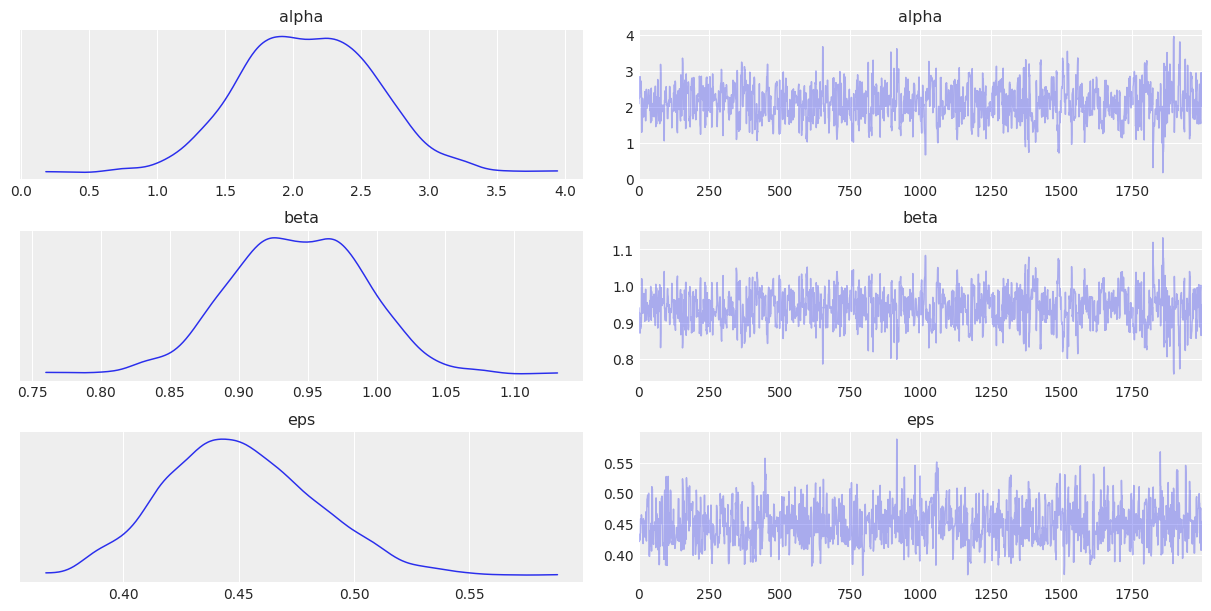

In [22]:
az.plot_trace(pyro_data, var_names=['alpha', 'beta', 'eps']);

### record trace

In [23]:
trace = Predictive(model_g, posterior_samples).get_vectorized_trace(x_tensor, y_tensor)
trace.compute_log_prob()
trace.nodes["obs"]["log_prob"]

tensor([[-1.9803, -0.3993, -0.2740,  ..., -0.0751, -0.3761, -0.3444],
        [-1.6664, -0.4732, -0.3649,  ..., -0.0608, -0.4692, -0.2631],
        [-1.8470, -0.4045, -0.2981,  ..., -0.0820, -0.3924, -0.3412],
        ...,
        [-1.5114, -0.4036, -0.3760,  ..., -0.0301, -0.4446, -0.2778],
        [-1.8174, -0.4641, -0.3278,  ..., -0.1127, -0.4349, -0.3224],
        [-1.6159, -0.4223, -0.3472,  ..., -0.1298, -0.4241, -0.3604]],
       dtype=torch.float64)

### SVI
#### Using an AutoGuide

In [24]:
autoguide = True

if autoguide:
    from pyro.infer.autoguide import AutoDiagonalNormal
    guide = AutoDiagonalNormal(model_g)
else:
    from torch.distributions import constraints
    def guide(x, y):
        alpha_loc = pyro.param('alpha_loc', torch.tensor(0.)).to(device)
        alpha_scale = pyro.param('alpha_scale', torch.tensor(1.),
                             constraint=constraints.positive).to(device)
        eps_loc = pyro.param('eps_loc', torch.tensor(1.),
                                 constraint=constraints.positive).to(device)
        beta_loc = pyro.param('beta_loc', torch.tensor(0.)).to(device)
        beta_scale = pyro.param('beta_scale', torch.tensor(1.),
                             constraint=constraints.positive).to(device)
        
        alpha = pyro.sample("alpha", dist.Normal(alpha_loc, alpha_scale)).to(device)
        beta = pyro.sample("beta", dist.Normal(beta_loc, beta_scale)).to(device)
        eps = pyro.sample("eps", dist.Normal(eps_loc, torch.tensor(0.05))).to(device)
        mu = alpha + beta * x

In [25]:
# optimizing
from pyro.infer import SVI, Trace_ELBO

adam = pyro.optim.Adam({"lr": 0.03})
svi = SVI(model_g, guide, adam, loss=Trace_ELBO())

In [26]:
num_iterations = 2000

In [27]:
%%time
pyro.clear_param_store()
for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(x_tensor, y_tensor)
    if j % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(y_tensor)))

[iteration 0001] loss: 3.9207
[iteration 0101] loss: 1.1316
[iteration 0201] loss: 0.7603
[iteration 0301] loss: 0.7561
[iteration 0401] loss: 0.8037
[iteration 0501] loss: 0.7733
[iteration 0601] loss: 0.7905
[iteration 0701] loss: 0.8333
[iteration 0801] loss: 0.7941
[iteration 0901] loss: 0.8004
[iteration 1001] loss: 0.7507
[iteration 1101] loss: 0.8366
[iteration 1201] loss: 0.7792
[iteration 1301] loss: 0.7874
[iteration 1401] loss: 0.7477
[iteration 1501] loss: 0.7727
[iteration 1601] loss: 0.7624
[iteration 1701] loss: 0.7872
[iteration 1801] loss: 0.7795
[iteration 1901] loss: 0.7552
CPU times: user 6.81 s, sys: 9.79 ms, total: 6.82 s
Wall time: 6.81 s


In [28]:
# stop updating weight/parameters
guide.requires_grad_(False)

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

AutoDiagonalNormal.loc Parameter containing:
tensor([ 2.0801,  0.9558, -0.7933])
AutoDiagonalNormal.scale tensor([0.0449, 0.0046, 0.0664])


In [29]:
guide.quantiles([0.25, 0.5, 0.75])

{'alpha': [tensor(2.0498), tensor(2.0801), tensor(2.1104)],
 'beta': [tensor(0.9527), tensor(0.9558), tensor(0.9589)],
 'eps': [tensor(0.4326), tensor(0.4524), tensor(0.4731)]}

In [30]:
num_sumples = 2000
predictive = Predictive(model_g, guide=guide, num_samples=num_sumples)
svi_samples = {k: v.reshape(num_samples).detach().cpu()
               for k, v in predictive(x_tensor, y_tensor).items()
               if k != "obs"}
svi_samples

{'alpha': tensor([2.0535, 2.0542, 2.1407,  ..., 2.0665, 2.0980, 2.1078]),
 'beta': tensor([0.9595, 0.9573, 0.9539,  ..., 0.9550, 0.9476, 0.9577]),
 'eps': tensor([0.4266, 0.4009, 0.4142,  ..., 0.4459, 0.5461, 0.4277])}

In [31]:
svi_posterior_predictive = {k: v.detach().cpu()
               for k, v in predictive(x_tensor).items()
               if k == "obs"}
svi_posterior_predictive

{'obs': tensor([[11.3923, 12.9567, 12.1434,  ..., 12.4606, 11.9926, 12.8392],
         [12.2371, 13.2514, 13.2820,  ..., 12.3486, 12.6890, 12.9097],
         [10.4603, 12.5722, 11.0483,  ..., 12.5771, 12.6918, 12.3742],
         ...,
         [10.9641, 12.6713, 11.5232,  ..., 11.7699, 12.4255, 13.0899],
         [10.7574, 12.6036, 11.3965,  ..., 12.9159, 12.3667, 12.2256],
         [10.4723, 11.8982, 13.0225,  ..., 12.3425, 12.3998, 12.4263]],
        dtype=torch.float64)}

### Summary table

In [32]:
get_summary_table(svi_posterior_predictive, ['obs'])

{'obs':          mean       std     median       5.0%      95.0%
 0   11.204560  0.453794  11.209095  10.418192  11.867963
 1   12.801731  0.465164  12.810372  12.082296  13.586762
 2   12.017934  0.465662  12.014772  11.269817  12.781246
 3   12.207997  0.446737  12.202276  11.512216  12.977747
 4   10.601961  0.451551  10.604318   9.859381  11.324108
 ..        ...       ...        ...        ...        ...
 95  10.054513  0.457781  10.053466   9.292552  10.793156
 96  12.219736  0.464803  12.218116  11.381760  12.879622
 97  12.031254  0.460064  12.033475  11.200030  12.710534
 98  12.395738  0.467764  12.406089  11.683948  13.228619
 99  12.653066  0.470577  12.664932  11.954950  13.466580
 
 [100 rows x 5 columns]}

In [33]:
get_summary_table(posterior_samples, ['alpha', 'beta', 'eps'])

{'alpha':        mean       std    median      5.0%    95.0%
 0  2.106218  0.491215  2.105067  1.273912  2.83025,
 'beta':        mean      std    median     5.0%     95.0%
 0  0.941848  0.04815  0.942108  0.87093  1.022543,
 'eps':        mean       std    median      5.0%    95.0%
 0  0.450461  0.032171  0.448372  0.402336  0.50841}

### plot trace

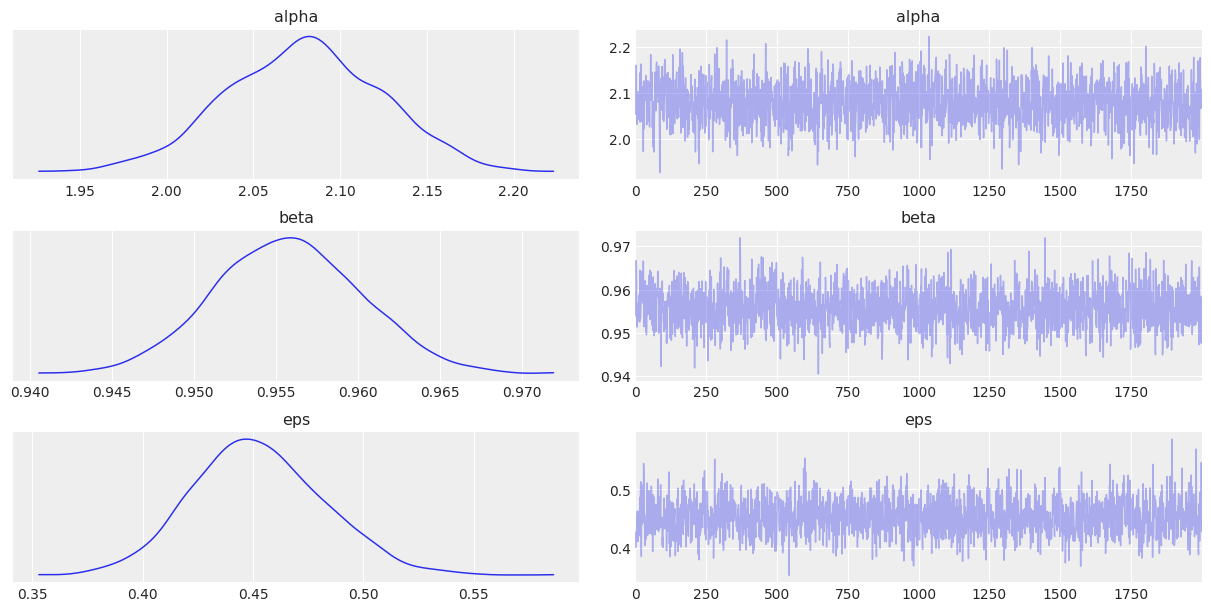

In [34]:
trace_g_svi = az.convert_to_inference_data(svi_samples)
az.plot_trace(trace_g_svi, compact=True);

### detailed info is here. https://pyro.ai/examples/bayesian_regression_ii.html#

https://pyro.ai/examples/bayesian_regression.html#Using-an-AutoGuide

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


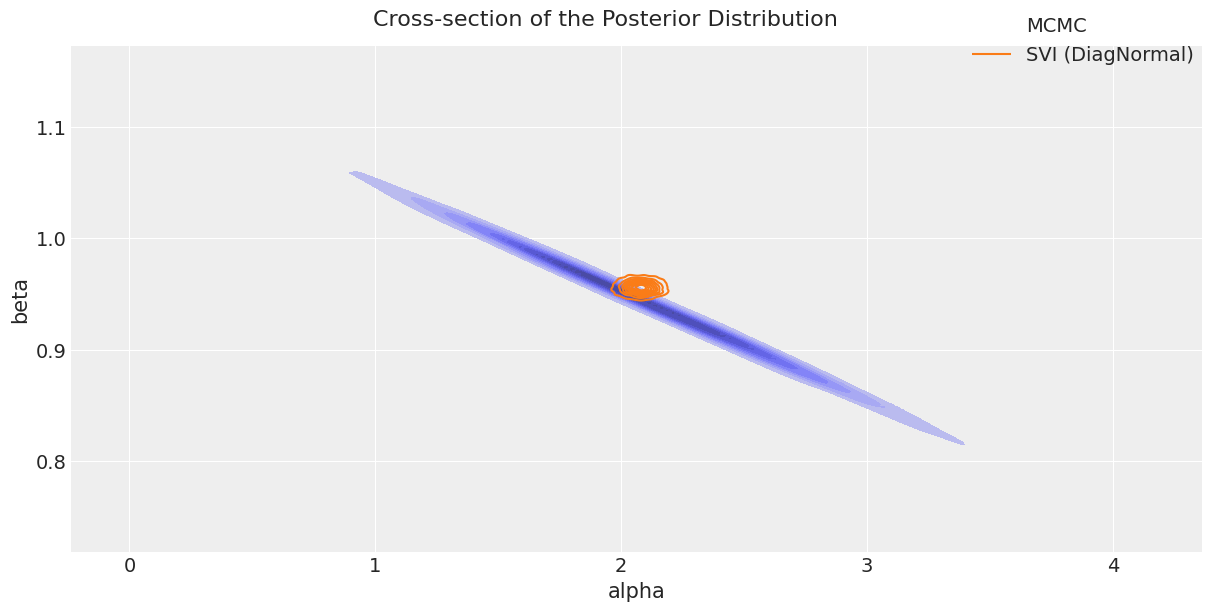

In [35]:
import seaborn as sns
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
fig.suptitle("Cross-section of the Posterior Distribution", fontsize=16)
# mcmc
sns.kdeplot(posterior_samples["alpha"], posterior_samples["beta"],
            ax=axs, shade=True, label="MCMC")
# SVI
sns.kdeplot(svi_samples["alpha"], svi_samples["beta"], ax=axs, label="SVI (DiagNormal)")
# sns.kdeplot(hmc_samples["bR"], hmc_samples["bAR"], ax=axs[1], shade=True, label="HMC")
# sns.kdeplot(svi_samples["bR"], svi_samples["bAR"], ax=axs[1], label="SVI (DiagNormal)")
axs.set(xlabel="alpha", ylabel="beta")#, xlim=(0.0, 5.0), ylim=(0.55, 1.0))
handles, labels = axs.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');

### interpreting the posterior

In [36]:
draws = range(0, len(posterior_samples['alpha']), 10)
posterior_samples['alpha'].shape

torch.Size([2000])

In [37]:
posterior_samples['alpha'][draws].shape

torch.Size([200])

In [38]:
def plot_posterior_1(x, y, posterior_samples):
    plt.plot(x, y, 'C0.')

    alpha_m = posterior_samples['alpha'].mean()
    beta_m = posterior_samples['beta'].mean()

    draws = range(0, len(posterior_samples['alpha']), 10)
    plt.plot(x, posterior_samples['alpha'][draws] + posterior_samples['beta'][draws]
             * x[:, np.newaxis], c='gray', alpha=0.5)

    plt.plot(x, alpha_m + beta_m * x, c='k',
             label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')

    plt.xlabel('x')
    plt.ylabel('y', rotation=0)
    plt.legend()
#     plt.savefig('B11197_03_05.png', dpi=300)

#### MCMC

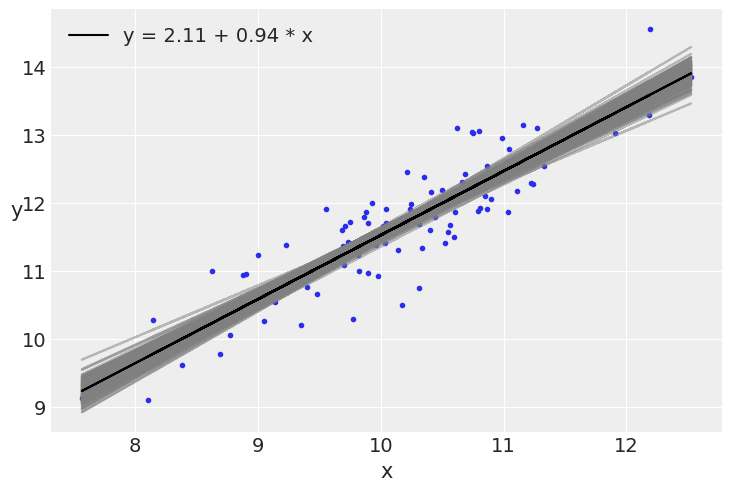

In [39]:
plot_posterior_1(x, y, posterior_samples)

#### SVI

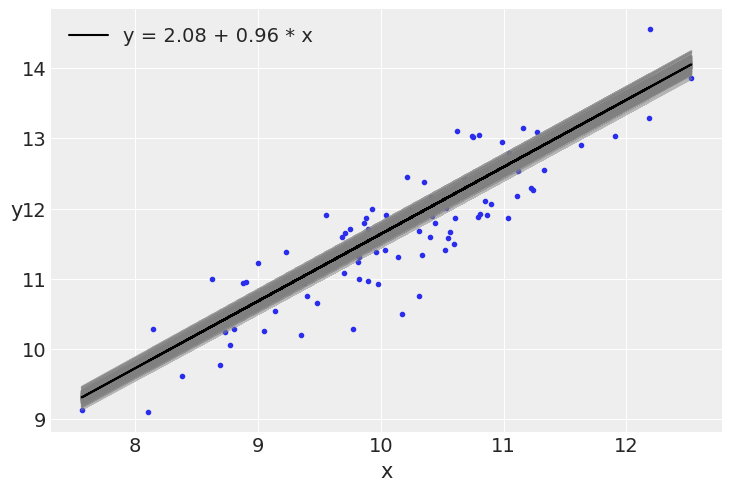

In [40]:
plot_posterior_1(x, y, svi_samples)

In [41]:
def plot_posterior_2(x, y, posterior_samples, credible_interval=0.98):
    fig, ax = plt.subplots()
    alpha_m = posterior_samples['alpha'].mean()
    beta_m = posterior_samples['beta'].mean()
    
    ax.plot(x, alpha_m + beta_m * x, c='k',
             label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')
    
    out = np.dot(posterior_samples['beta'].reshape(-1,1).numpy(), x.reshape(1,-1)) + posterior_samples['alpha'].reshape(-1,1).numpy()
    sig = az.plot_hpd(x, out, hdi_prob=credible_interval, color='k', ax=ax)

    plt.xlabel('x')
    plt.ylabel('y', rotation=0)
    plt.legend()
#     plt.savefig('B11197_03_06.png', dpi=300)

/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


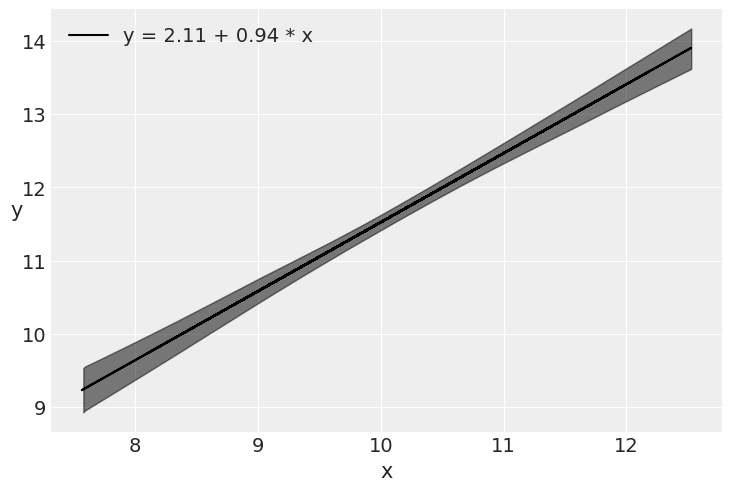

In [42]:
# MCMC
plot_posterior_2(x, y, posterior_samples)

/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


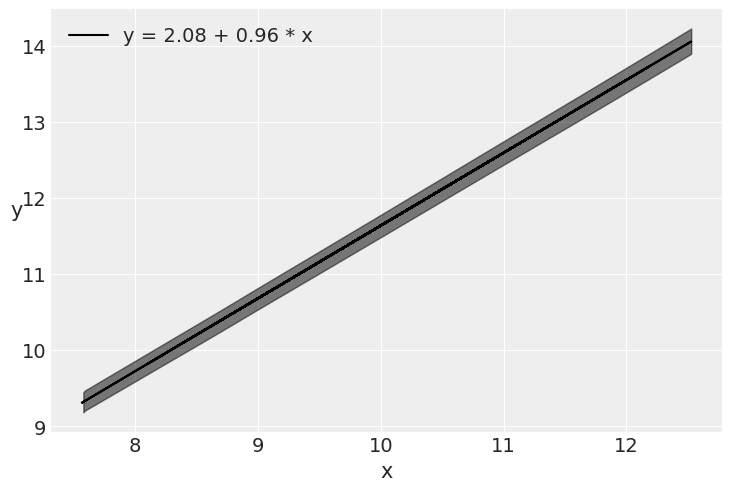

In [43]:
# SVI
plot_posterior_2(x, y, svi_samples)

In [44]:
def plot_posterior_3(x, y, posterior_samples, posterior_predictive):
    fig, ax = plt.subplots()
    
    ax.plot(x, y, 'b.')
    
    alpha_m = posterior_samples['alpha'].mean()
    beta_m = posterior_samples['beta'].mean()
    
    ax.plot(x, alpha_m + beta_m * x, c='k',
             label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')
    
#     sig = az.plot_hpd(x, posterior_predictive['obs'], credible_interval=0.98, color='k', ax=ax)
    
    az.plot_hpd(x, posterior_predictive['obs'], hdi_prob=0.5, color='gray',ax=ax)
    az.plot_hpd(x, posterior_predictive['obs'], color='gray',ax=ax)
    
    plt.xlabel('x')
    plt.ylabel('y', rotation=0)
    plt.legend()
#     plt.savefig('B11197_03_06.png', dpi=300)

/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


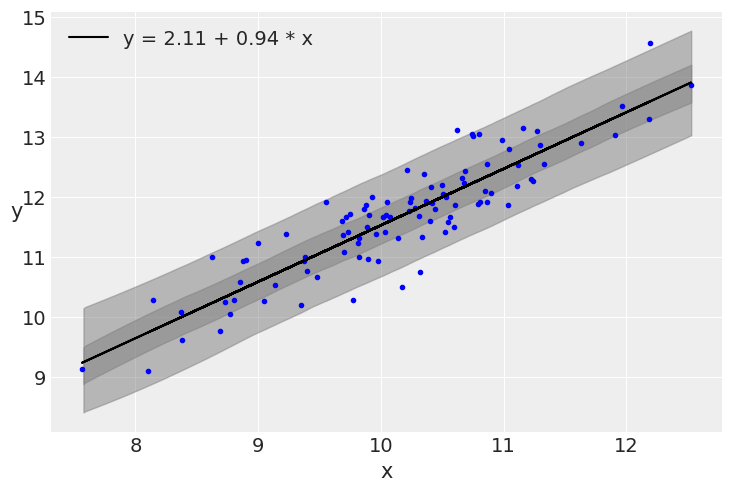

In [45]:
# MCMC
plot_posterior_3(x, y, posterior_samples, posterior_predictive)

/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


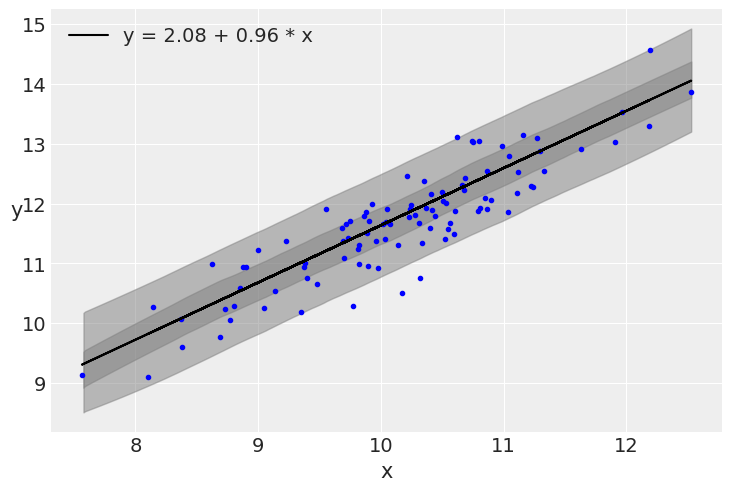

In [46]:
# SVI
plot_posterior_3(x, y, svi_samples, svi_posterior_predictive)

### The multivariate normal distribution 
Actually the bivariate

In [ ]:
# sigma_x1 = 1
# sigmas_x2 = [1, 2]
# rhos = [-0.90, -0.5, 0, 0.5, 0.90]

# k, l = np.mgrid[-5:5:.1, -5:5:.1]
# pos = np.empty(k.shape + (2,))
# pos[:, :, 0] = k
# pos[:, :, 1] = l

# f, ax = plt.subplots(len(sigmas_x2), len(rhos),
#                      sharex=True, sharey=True, figsize=(12, 6),
#                      constrained_layout=True)
# for i in range(2):
#     for j in range(5):
#         sigma_x2 = sigmas_x2[i]
#         rho = rhos[j]
#         cov = [[sigma_x1**2, sigma_x1*sigma_x2*rho],
#                [sigma_x1*sigma_x2*rho, sigma_x2**2]]
#         rv = stats.multivariate_normal([0, 0], cov)
#         ax[i, j].contour(k, l, rv.pdf(pos))
#         ax[i, j].set_xlim(-8, 8)
#         ax[i, j].set_ylim(-8, 8)
#         ax[i, j].set_yticks([-5, 0, 5])
#         ax[i, j].plot(0, 0,
#                       label=f'$\\sigma_{{x2}}$ = {sigma_x2:3.2f}\n$\\rho$ = {rho:3.2f}', alpha=0)
#         ax[i, j].legend()
# f.text(0.5, -0.05, 'x_1', ha='center', fontsize=18)
# f.text(-0.05, 0.5, 'x_2', va='center', fontsize=18, rotation=0)
# plt.savefig('B11197_03_08.png', dpi=300)

In [ ]:
# %%time
# data = np.stack((x, y)).T
# with pm.Model() as pearson_model:

#     mu = pm.Normal('mu', mu=data.mean(0), sd=10, shape=2)

#     σ_1 = pm.HalfNormal('σ_1', 10)
#     σ_2 = pm.HalfNormal('σ_2', 10)
#     ρ = pm.Uniform('ρ', -1., 1.)
#     r2 = pm.Deterministic('r2', ρ**2)

#     cov = pm.math.stack(([σ_1**2, σ_1*σ_2*ρ],
#                          [σ_1*σ_2*ρ, σ_2**2]))

#     y_pred = pm.MvNormal('y_pred', mu=mu, cov=cov, observed=data)

#     trace_p = pm.sample(1000)

In [ ]:
# type(trace_p)

In [ ]:
# az.plot_trace(trace_p, var_names=['r2'])
# plt.savefig('B11197_03_9.png', dpi=300)

In [ ]:
# az.summary(trace_p, var_names=['r2'])

## Robust linear regression

In [6]:
ans = pd.read_csv('../data/anscombe.csv')
x_3 = ans[ans.group == 'III']['x'].values
y_3 = ans[ans.group == 'III']['y'].values
x_3 = x_3 - x_3.mean()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  if sys.path[0] == '':


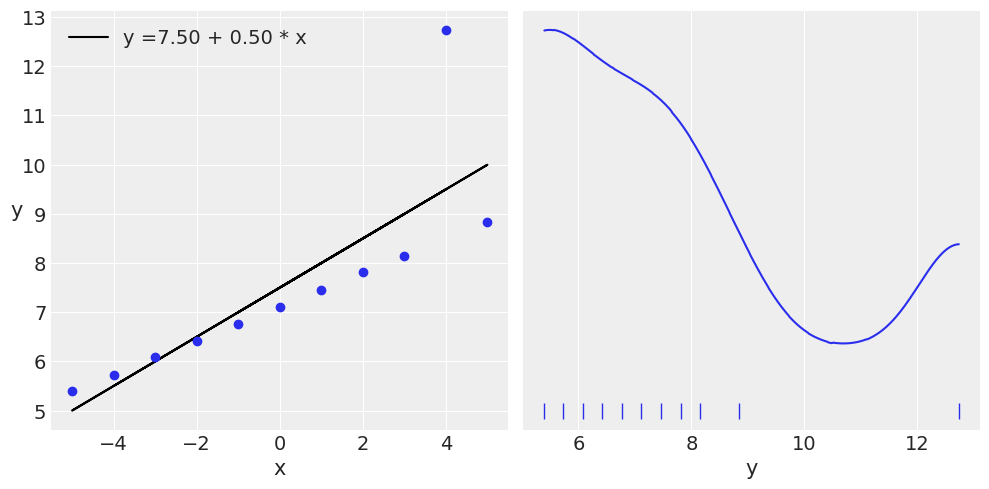

In [7]:
_, ax = plt.subplots(1, 2, figsize=(10, 5))
beta_c, alpha_c = stats.linregress(x_3, y_3)[:2]
ax[0].plot(x_3, (alpha_c + beta_c * x_3), 'k',
           label=f'y ={alpha_c:.2f} + {beta_c:.2f} * x')
ax[0].plot(x_3, y_3, 'C0o')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y', rotation=0)
ax[0].legend(loc=0)
az.plot_kde(y_3, ax=ax[1], rug=True)
ax[1].set_xlabel('y')
ax[1].set_yticks([])
plt.tight_layout()
plt.savefig('B11197_03_10.png', dpi=300)

In [88]:
y_3.mean()

7.5

In [89]:
def model_t(x, y=None):
    alpha = pyro.sample('alpha', dist.Normal(loc=7.5, scale=1)).to(device)
    beta = pyro.sample('beta', dist.Normal(loc=0, scale=1)).to(device)
    eps = pyro.sample('eps', dist.HalfNormal(5.)).to(device)
    nu_ = pyro.sample('nu_', dist.Exponential(1/29)).to(device)
    nu = nu_ + 1
    
    mu = alpha + beta * x
    
    if use_cuda:
        with pyro.plate("plate", size=x.shape[0], use_cuda=use_cuda):
            return pyro.sample("obs", dist.StudentT(df=nu, loc=mu, scale=eps), obs=y)
    else:
        with pyro.plate("plate", size=x.shape[0], use_cuda=None):
            return pyro.sample("obs", dist.StudentT(df=nu, loc=mu, scale=eps), obs=y)

In [90]:
x_tensor = torch.from_numpy(x_3).to(device)
y_tensor = torch.from_numpy(y_3).to(device)
x_tensor.shape, y_tensor.shape

(torch.Size([11]), torch.Size([11]))

### MCMC

In [92]:
%%time
pyro.clear_param_store() 

nuts_kernel = NUTS(model_t)
mcmc = MCMC(nuts_kernel, num_samples=2000, warmup_steps=1000, num_chains=1)
# mcmc = MCMC(nuts_kernel, num_samples=200, warmup_steps=50, num_chains=1)
mcmc.run(x_tensor, y_tensor)
posterior_samples = mcmc.get_samples()

Sample: 100%|██████████| 3000/3000 [03:42, 13.50it/s, step size=9.17e-02, acc. prob=0.857]

CPU times: user 3min 42s, sys: 530 ms, total: 3min 42s
Wall time: 3min 42s


In [112]:
mcmc.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      7.11      0.00      7.11      7.11      7.12   1398.77      1.00
      beta      0.35      0.00      0.35      0.34      0.35   1677.03      1.00
       eps      0.00      0.00      0.00      0.00      0.01    460.01      1.00
       nu_      0.22      0.21      0.16      0.00      0.50    604.98      1.00

Number of divergences: 0


In [115]:
posterior_samples

{'alpha': tensor([7.1149, 7.1154, 7.1141,  ..., 7.1144, 7.1138, 7.1158],
        dtype=torch.float64),
 'beta': tensor([0.3449, 0.3455, 0.3447,  ..., 0.3454, 0.3450, 0.3456],
        dtype=torch.float64),
 'eps': tensor([0.0021, 0.0020, 0.0014,  ..., 0.0029, 0.0052, 0.0051],
        dtype=torch.float64),
 'nu_': tensor([0.0839, 0.1249, 0.1971,  ..., 0.1164, 0.0288, 0.0269],
        dtype=torch.float64)}

In [116]:
posterior_predictive = Predictive(model_t, posterior_samples)(x_tensor, None)
posterior_predictive

{'obs': tensor([[7.4573, 6.7684, 8.4974,  ..., 8.1491, 6.4254, 5.7333],
         [7.4582, 6.6916, 8.4973,  ..., 8.1508, 6.4222, 5.7352],
         [7.4593, 6.8610, 8.4916,  ..., 8.1477, 6.4294, 5.7313],
         ...,
         [7.4609, 6.7678, 8.4967,  ..., 8.1505, 6.4310, 5.7045],
         [7.4343, 6.7660, 8.4972,  ..., 8.1481, 6.4302, 5.7303],
         [7.4703, 6.7473, 8.5022,  ..., 8.1606, 6.4410, 5.7282]],
        dtype=torch.float64)}

### Summary table

#### version 1

In [117]:
get_summary_table(posterior_predictive, ['obs'])

{'obs':         mean       std    median      5.0%     95.0%
 0   7.459684  0.049076  7.459518  7.445328  7.476025
 1   6.769780  0.086829  6.768994  6.751183  6.784577
 2   8.497736  0.153800  8.495254  8.478218  8.511079
 3   7.112282  0.127388  7.114454  7.098179  7.127548
 4   7.804542  0.042385  7.804871  7.790790  7.818516
 5   8.841072  0.052876  8.840581  8.823157  8.855693
 6   6.077737  0.055309  6.078357  6.061668  6.093152
 7   5.388443  0.045266  5.387830  5.371311  5.403517
 8   8.150321  0.045656  8.150173  8.132901  8.166154
 9   6.422083  0.077067  6.423689  6.406229  6.438072
 10  5.729368  0.168332  5.733092  5.718928  5.747780}

In [118]:
get_summary_table(posterior_samples, ['alpha', 'beta', 'eps'])

{'alpha':        mean      std   median      5.0%     95.0%
 0  7.114171  0.00143  7.11429  7.111739  7.116185,
 'beta':        mean       std    median      5.0%     95.0%
 0  0.345324  0.000439  0.345277  0.344668  0.346046,
 'eps':        mean       std    median      5.0%     95.0%
 0  0.003264  0.001721  0.002864  0.001121  0.005402}

#### version 2

In [119]:
get_summary_table_pandas(posterior_predictive, ['obs'], percentiles=[.05, 0.95])

{'obs':      count      mean       std       min        5%       50%       95%  \
 0   2000.0  7.459684  0.049076  6.524433  7.443819  7.459519  7.475107   
 1   2000.0  6.769780  0.086829  5.785061  6.751143  6.768995  6.784547   
 2   2000.0  8.497736  0.153800  6.196837  8.478709  8.495259  8.512689   
 3   2000.0  7.112282  0.127388  1.774348  7.098605  7.114456  7.128185   
 4   2000.0  7.804542  0.042385  6.562167  7.791735  7.804872  7.820575   
 5   2000.0  8.841072  0.052876  7.186317  8.824845  8.840582  8.857602   
 6   2000.0  6.077737  0.055309  3.958397  6.062668  6.078359  6.094295   
 7   2000.0  5.388443  0.045266  4.551731  5.371321  5.387832  5.403519   
 8   2000.0  8.150321  0.045656  7.300841  8.133926  8.150174  8.167569   
 9   2000.0  6.422083  0.077067  4.280947  6.407844  6.423689  6.439823   
 10  2000.0  5.729368  0.168332 -1.535386  5.718374  5.733092  5.747328   
 
           max  
 0    8.487042  
 1    9.885337  
 2   14.687914  
 3    8.345077  
 4    

In [120]:
get_summary_table_pandas(posterior_samples, ['alpha', 'beta', 'eps'], percentiles=[.05, 0.95])

{'alpha':     count      mean      std       min        5%      50%       95%       max
 0  2000.0  7.114171  0.00143  7.105888  7.111749  7.11429  7.116229  7.120685,
 'beta':     count      mean       std       min        5%       50%       95%  \
 0  2000.0  0.345324  0.000439  0.343361  0.344704  0.345277  0.346092   
 
         max  
 0  0.348286  ,
 'eps':     count      mean       std       min        5%       50%       95%  \
 0  2000.0  0.003264  0.001721  0.000919  0.001426  0.002864  0.006179   
 
         max  
 0  0.019179  }

### plot trace

In [121]:
num_samples=2000
prior = Predictive(model_t, num_samples=num_samples).get_samples(x_tensor, y_tensor)

In [122]:
pyro_data = az.from_pyro(
    mcmc,
    prior=prior,
    posterior_predictive=posterior_predictive
)
pyro_data

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

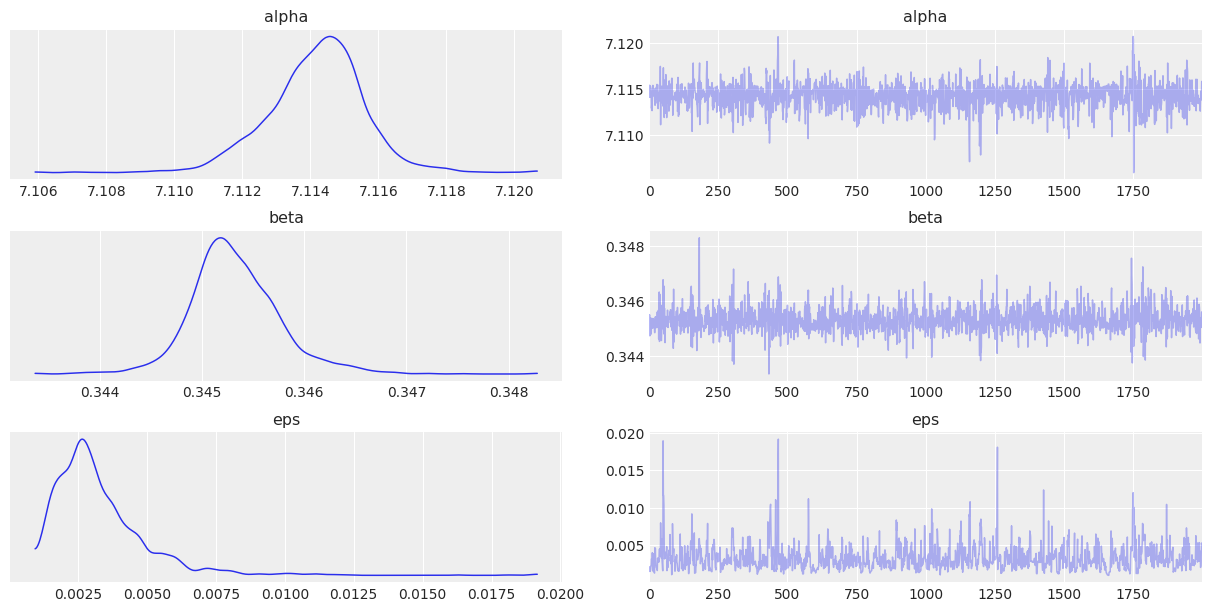

In [123]:
az.plot_trace(pyro_data, var_names=['alpha', 'beta', 'eps']);

### record trace

In [124]:
trace = Predictive(model_t, posterior_samples).get_vectorized_trace(x_tensor, y_tensor)
trace.compute_log_prob()
trace.nodes["obs"]["log_prob"]

tensor([[  5.0439,   5.0510, -10.7587,  ...,   5.0302,   3.1199,   3.0769],
        [  4.9085,   5.0704, -11.0393,  ...,   4.4695,   3.3407,   3.7611],
        [  4.9377,   5.2501, -11.9259,  ...,   4.5792,   2.9579,   2.7453],
        ...,
        [  4.7248,   4.6235, -10.6078,  ...,   4.7129,   3.7838,   4.0337],
        [  4.0634,   4.0561,  -9.4449,  ...,   4.0703,   3.7096,   3.7256],
        [  4.0618,   4.1321,  -9.4568,  ...,   3.9040,   3.5491,   3.7764]],
       dtype=torch.float64)

#### output

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  


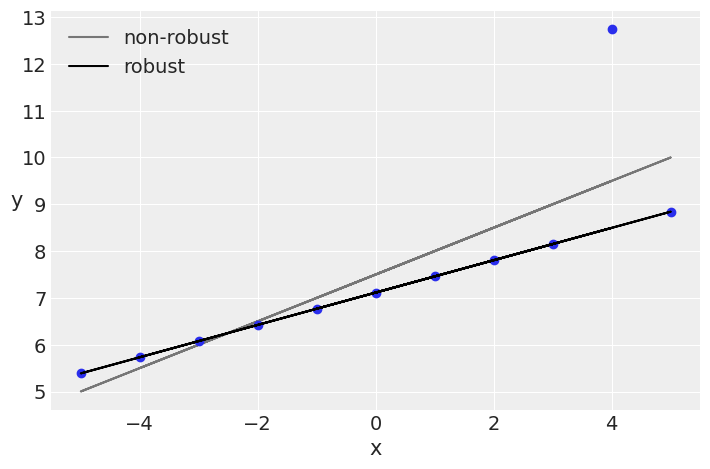

In [128]:
beta_c, alpha_c = stats.linregress(x_3, y_3)[:2]

plt.plot(x_3, (alpha_c + beta_c * x_3), 'k', label='non-robust', alpha=0.5)
plt.plot(x_3, y_3, 'C0o')


alpha_m = get_summary_table(posterior_samples, ['alpha'], diagnostics=False, group_by_chain=False, prob=0.9)['alpha']['mean'].values[0]
beta_m = get_summary_table(posterior_samples, ['beta'], diagnostics=False, group_by_chain=False, prob=0.9)['beta']['mean'].values[0]
plt.plot(x_3, alpha_m + beta_m * x_3, c='k', label='robust')

plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.legend(loc=2)
plt.tight_layout()

# plt.savefig('B11197_03_11.png', dpi=300)

(0.0, 12.0)

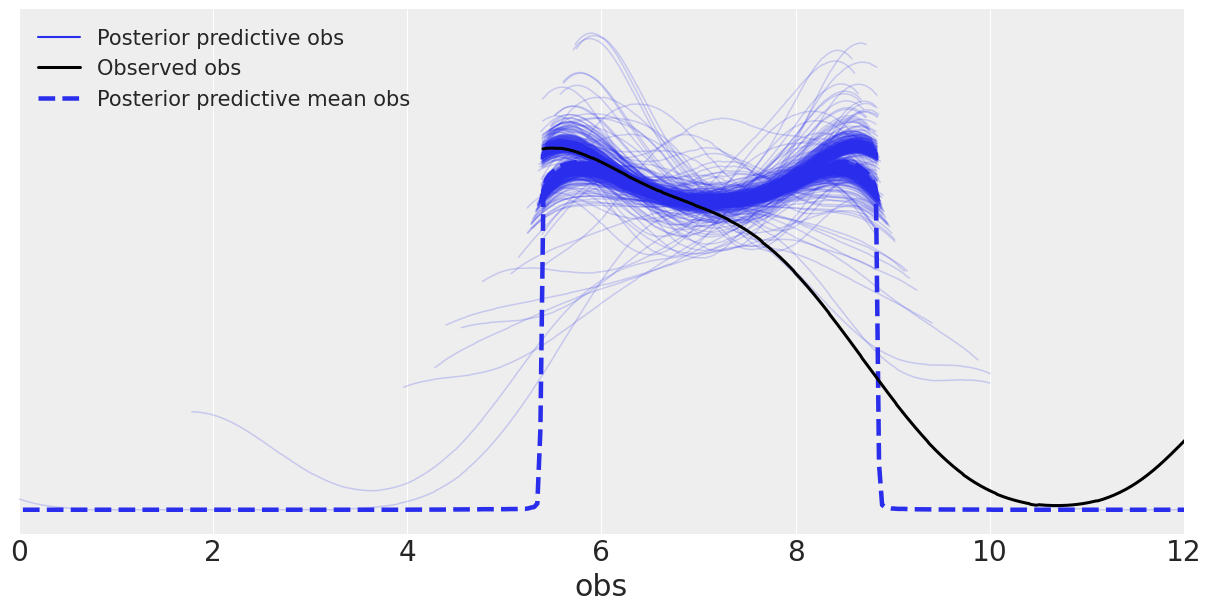

In [129]:
# data_ppc = az.from_pymc3(trace=trace_t, posterior_predictive=ppc)
ax = az.plot_ppc(pyro_data, figsize=(12, 6), mean=True)
plt.xlim(0, 12)
# plt.savefig('B11197_03_12.png', dpi=300)

## Hierarchical linear regression

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


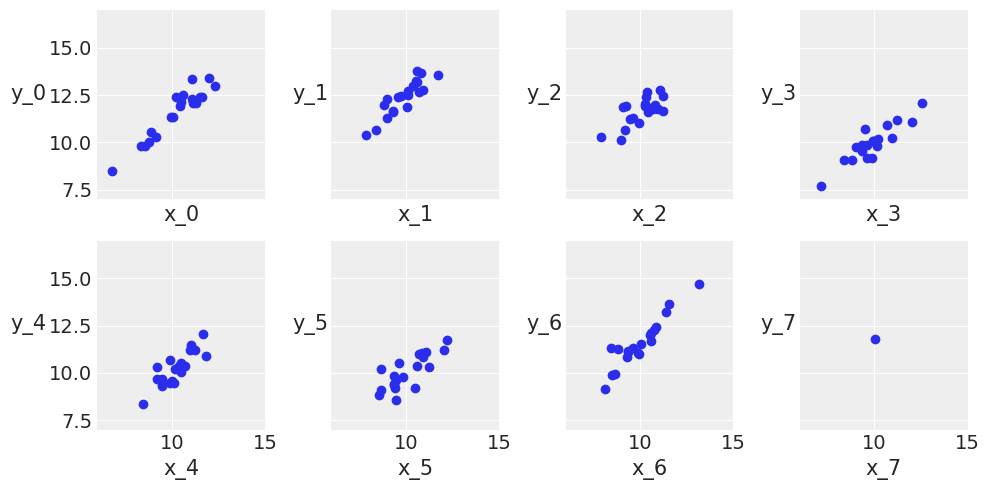

In [130]:
N = 20
M = 8
idx = np.repeat(range(M-1), N)
idx = np.append(idx, 7)
np.random.seed(314)

alpha_real = np.random.normal(2.5, 0.5, size=M)
beta_real = np.random.beta(6, 1, size=M)
eps_real = np.random.normal(0, 0.5, size=len(idx))

y_m = np.zeros(len(idx))
x_m = np.random.normal(10, 1, len(idx))
y_m = alpha_real[idx] + beta_real[idx] * x_m + eps_real

_, ax = plt.subplots(2, 4, figsize=(10, 5), sharex=True, sharey=True)
ax = np.ravel(ax)
j, k = 0, N
for i in range(M):
    ax[i].scatter(x_m[j:k], y_m[j:k])
    ax[i].set_xlabel(f'x_{i}')
    ax[i].set_ylabel(f'y_{i}', rotation=0, labelpad=15)
    ax[i].set_xlim(6, 15)
    ax[i].set_ylim(7, 17)
    j += N
    k += N
plt.tight_layout()
plt.savefig('B11197_03_13.png', dpi=300)

In [131]:
x_centered = x_m - x_m.mean()

### unpooled (non-hierarchical) mode

In [280]:
def model_unpooled(idx, M, x, y=None):
    x_centered = x - x.mean()
    
    alpha_tmp = pyro.sample('alpha_tmp', dist.Normal(loc=torch.zeros(M), scale=10)).to(device)
    beta = pyro.sample('beta', dist.Normal(loc=torch.zeros(M), scale=10)).to(device)
    eps = pyro.sample('eps', dist.HalfCauchy(5.)).to(device)
    nu = pyro.sample('nu_', dist.Exponential(1/30)).to(device) 
    
    mu = alpha_tmp[idx] + beta[idx] * x_centered
    
    # add deterministric
    alpha = deterministic('alpha', alpha_tmp - beta * x.mean(), 0)
    
    if use_cuda:
        with pyro.plate("plate", size=x.shape[0], use_cuda=use_cuda):
            return pyro.sample("obs", dist.StudentT(df=nu, loc=mu, scale=eps), obs=y)
    else:
        with pyro.plate("plate", size=x.shape[0], use_cuda=None):
            return pyro.sample("obs", dist.StudentT(df=nu, loc=mu, scale=eps), obs=y)

### MCMC

In [282]:
%%time
pyro.clear_param_store() 

nuts_kernel = NUTS(model_unpooled)
mcmc = MCMC(nuts_kernel, num_samples=2000, warmup_steps=1000, num_chains=1)
# mcmc = MCMC(nuts_kernel, num_samples=200, warmup_steps=50, num_chains=1)
mcmc.run(idx, M, x_tensor, y_tensor)
posterior_samples = mcmc.get_samples()

Sample: 100%|██████████| 3000/3000 [01:10, 42.29it/s, step size=5.69e-01, acc. prob=0.868]

CPU times: user 1min 10s, sys: 216 ms, total: 1min 11s
Wall time: 1min 10s


In [283]:
mcmc.summary()


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
alpha_tmp[0]     11.42      0.11     11.41     11.24     11.60   3805.39      1.00
alpha_tmp[1]     12.52      0.11     12.52     12.34     12.70   4657.63      1.00
alpha_tmp[2]     11.64      0.11     11.64     11.46     11.81   3851.66      1.00
alpha_tmp[3]     10.08      0.10     10.09      9.91     10.25   3837.28      1.00
alpha_tmp[4]     10.06      0.11     10.06      9.87     10.22   3925.60      1.00
alpha_tmp[5]     10.03      0.11     10.03      9.85     10.21   4634.83      1.00
alpha_tmp[6]     11.64      0.10     11.64     11.45     11.79   3972.06      1.00
alpha_tmp[7]     11.78      0.49     11.77     10.96     12.53   3625.55      1.00
     beta[0]      0.89      0.08      0.89      0.77      1.02   4420.07      1.00
     beta[1]      0.88      0.11      0.88      0.69      1.06   3691.27      1.00
     beta[2]      0.60      0.13      0.59      0.40      0.82   3842.26      1.00
   

In [284]:
posterior_samples

{'alpha_tmp': tensor([[11.6438, 12.5056, 11.5660,  ..., 10.0618, 11.6662, 11.3848],
         [11.2290, 12.5789, 11.7442,  ...,  9.9147, 11.6395, 12.0640],
         [11.5319, 12.4054, 11.5398,  ...,  9.9971, 11.6770, 11.5657],
         ...,
         [11.4653, 12.7648, 11.6868,  ...,  9.9060, 11.5704, 11.8076],
         [11.2970, 12.3317, 11.7430,  ..., 10.1260, 11.7520, 11.8064],
         [11.4762, 12.7235, 11.4382,  ...,  9.9599, 11.4616, 11.9321]],
        dtype=torch.float64),
 'beta': tensor([[ 0.8091,  0.9270,  0.6769,  ...,  0.7139,  0.8904, -6.7543],
         [ 0.9562,  0.8361,  0.5050,  ...,  0.6109,  1.0587,  1.7811],
         [ 0.7845,  0.9758,  0.6724,  ...,  0.7298,  0.9273, -0.1420],
         ...,
         [ 0.8881,  0.7820,  0.6056,  ...,  0.6130,  1.1338,  7.9931],
         [ 0.9094,  1.0162,  0.5366,  ...,  0.8076,  0.8841, -5.7599],
         [ 0.8769,  0.7443,  0.6681,  ...,  0.6391,  1.1563,  6.7486]],
        dtype=torch.float64),
 'eps': tensor([0.4771, 0.4593, 0.446

In [285]:
posterior_predictive = Predictive(model_unpooled, posterior_samples)(idx, M, x_tensor, None)
posterior_predictive

Sample:  96%|█████████▌| 2871/3000 [13:42,  3.49it/s, step size=1.12e-01, acc. prob=0.900]


{'obs': tensor([[11.6170, 13.4430, 11.5401,  ..., 13.1409, 12.3729, 11.6600],
         [11.4988, 14.4402, 11.4791,  ..., 13.4337, 13.3513, 11.3201],
         [11.9447, 12.8458, 11.6371,  ..., 11.6620, 12.2128, 10.8425],
         ...,
         [ 9.9041, 12.7744, 11.5535,  ..., 14.2198, 13.6270, 11.3647],
         [10.6306, 13.0944, 11.1037,  ..., 12.6209, 12.7338, 11.7644],
         [12.0758, 12.1298, 11.9588,  ..., 13.0123, 13.0108, 11.9815]],
        dtype=torch.float64),
 'alpha': tensor([[  3.5185,   3.1963,   4.7689,  ...,   2.8924,   2.7246,  79.2125],
         [  1.6269,   4.1826,   6.6731,  ...,   3.7799,   1.0083,  -5.8223],
         [  3.6536,   2.6062,   4.7869,  ...,   2.6686,   2.3649,  12.9919],
         ...,
         [  2.5472,   4.9115,   5.6056,  ...,   3.7504,   0.1845, -68.4605],
         [  2.1644,   2.1272,   6.3542,  ...,   2.0162,   2.8738,  69.6483],
         [  2.6702,   5.2487,   4.7290,  ...,   3.5418,  -0.1504, -55.8385]],
        dtype=torch.float64)}

### Summary table

#### version 1

In [286]:
get_summary_table(posterior_predictive, ['obs', 'alpha'])

{'obs':           mean       std     median       5.0%      95.0%
 0    11.335211  0.489704  11.345212  10.581029  12.134073
 1    13.422238  0.527256  13.415393  12.577091  14.298123
 2    11.421599  0.482116  11.411484  10.606482  12.196315
 3    11.613556  0.489952  11.611967  10.862484  12.436504
 4    12.408406  0.502563  12.402411  11.599836  13.247417
 ..         ...       ...        ...        ...        ...
 136  12.174416  0.512025  12.177678  11.387607  13.041784
 137  14.685042  0.560030  14.692642  13.751427  15.562791
 138  13.079404  0.504860  13.063329  12.212525  13.866318
 139  12.432273  0.493462  12.449864  11.664311  13.256444
 140  11.781434  0.678037  11.770206  10.682379  12.889320
 
 [141 rows x 5 columns],
 'alpha':        mean        std    median        5.0%       95.0%
 0  2.437957   0.776614  2.444674    1.114607    3.581004
 1  3.723466   1.117976  3.709389    1.919836    5.563161
 2  5.654511   1.277933  5.691991    3.309383    7.555341
 3  3.056747   0.

In [287]:
get_summary_table(posterior_samples, ['alpha_tmp', 'beta', 'eps'])

{'alpha_tmp':         mean       std     median       5.0%      95.0%
 0  11.415533  0.108016  11.414368  11.244558  11.596292
 1  12.522045  0.107759  12.518972  12.342308  12.701993
 2  11.639488  0.108442  11.638784  11.464717  11.811193
 3  10.084860  0.103422  10.087064   9.914166  10.251480
 4  10.055882  0.109407  10.056963   9.872502  10.224743
 5  10.027742  0.109529  10.027080   9.845728  10.205399
 6  11.638180  0.103440  11.639976  11.452712  11.788393
 7  11.776362  0.486378  11.769888  10.955156  12.533154,
 'beta':        mean       std    median       5.0%      95.0%
 0  0.893989  0.075483  0.892037   0.774553   1.016341
 1  0.876164  0.112852  0.877116   0.689186   1.057586
 2  0.595985  0.125627  0.591984   0.398549   0.815961
 3  0.699861  0.086297  0.699264   0.564087   0.845127
 4  0.874762  0.131142  0.877032   0.658432   1.087859
 5  0.679238  0.101961  0.676744   0.511048   0.844051
 6  0.984113  0.087310  0.983755   0.847669   1.131250
 7  0.212641  9.734255  0

#### version 2

In [288]:
get_summary_table_pandas(posterior_predictive, ['obs','alpha'], percentiles=[.05, 0.95])

{'obs':       count       mean       std        min         5%        50%        95%  \
 0    2000.0  11.335211  0.489704   9.243457  10.539466  11.345428  12.100507   
 1    2000.0  13.422238  0.527256  11.736836  12.548136  13.415536  14.277339   
 2    2000.0  11.421599  0.482116   9.690071  10.635632  11.412045  12.225010   
 3    2000.0  11.613556  0.489952   9.417265  10.847057  11.612439  12.423906   
 4    2000.0  12.408406  0.502563  10.410819  11.589654  12.402589  13.243108   
 ..      ...        ...       ...        ...        ...        ...        ...   
 136  2000.0  12.174416  0.512025  10.211453  11.346085  12.177788  13.010783   
 137  2000.0  14.685042  0.560030  12.651173  13.763109  14.692704  15.590227   
 138  2000.0  13.079404  0.504860  11.369123  12.232970  13.063379  13.895144   
 139  2000.0  12.432273  0.493462  10.532771  11.629495  12.450159  13.233582   
 140  2000.0  11.781434  0.678037   9.034878  10.687054  11.770867  12.911590   
 
            max  
 

In [289]:
get_summary_table_pandas(posterior_samples, ['alpha_tmp', 'beta', 'eps'], percentiles=[.05, 0.95])

{'alpha_tmp':     count       mean       std        min         5%        50%        95%  \
 0  2000.0  11.415533  0.108016  10.960153  11.240866  11.414374  11.593589   
 1  2000.0  12.522045  0.107759  12.192751  12.340992  12.519186  12.701573   
 2  2000.0  11.639488  0.108442  11.286688  11.468510  11.638896  11.818743   
 3  2000.0  10.084860  0.103422   9.715259   9.911741  10.087064  10.250020   
 4  2000.0  10.055882  0.109407   9.604822   9.882782  10.057008  10.236297   
 5  2000.0  10.027742  0.109529   9.646249   9.847568  10.027147  10.208282   
 6  2000.0  11.638180  0.103440  11.280486  11.467594  11.640005  11.809537   
 7  2000.0  11.776362  0.486378   9.647409  10.984238  11.770073  12.569411   
 
          max  
 0  11.784918  
 1  12.842326  
 2  11.996396  
 3  10.482245  
 4  10.417158  
 5  10.442334  
 6  11.994114  
 7  13.684166  ,
 'beta':     count      mean       std        min         5%       50%        95%  \
 0  2000.0  0.893989  0.075483   0.633122   

### plot trace

In [290]:
num_samples=2000
prior = Predictive(model_unpooled, num_samples=num_samples).get_samples(idx, M, x_tensor, y_tensor)

In [291]:
mcmc

In [292]:
pyro_data = az.from_pyro(
    mcmc,
    prior=prior,
    posterior_predictive=posterior_predictive
)
pyro_data

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pyro.py:153: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  "Could not get vectorized trace, log_likelihood group will be omitted. "


Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

In [293]:
posterior_predictive['alpha']

tensor([[  3.5185,   3.1963,   4.7689,  ...,   2.8924,   2.7246,  79.2125],
        [  1.6269,   4.1826,   6.6731,  ...,   3.7799,   1.0083,  -5.8223],
        [  3.6536,   2.6062,   4.7869,  ...,   2.6686,   2.3649,  12.9919],
        ...,
        [  2.5472,   4.9115,   5.6056,  ...,   3.7504,   0.1845, -68.4605],
        [  2.1644,   2.1272,   6.3542,  ...,   2.0162,   2.8738,  69.6483],
        [  2.6702,   5.2487,   4.7290,  ...,   3.5418,  -0.1504, -55.8385]],
       dtype=torch.float64)

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

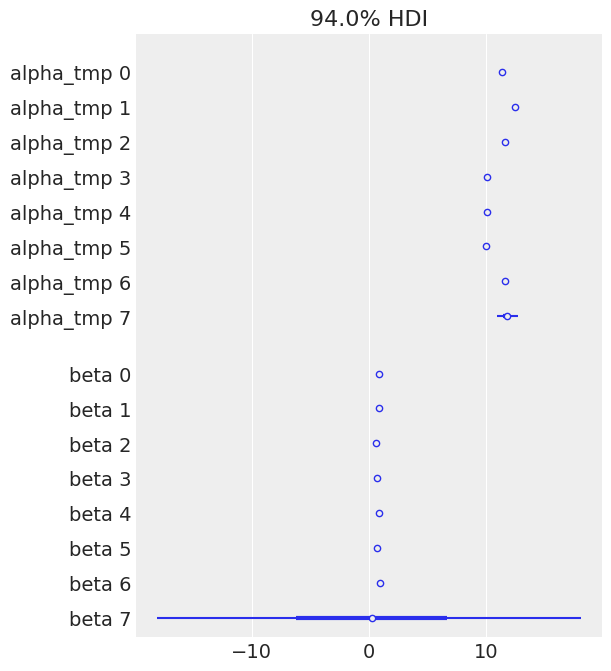

In [294]:
az.plot_forest(pyro_data, var_names=['alpha_tmp', 'beta'], combined=True)

In [295]:
# def model_hierarchical(idx, M, x, y=None):
#     x_centered = x - x.mean()
    
#     # hyper-priors
#     alpha_mu_tmp = pyro.sample('alpha_mu_tmp', dist.Normal(loc=0, scale=10)).to(device)
#     alpha_sigma_tmp = pyro.sample('alpha_sigma_tmp', dist.HalfNormal(10.)).to(device)
#     beta_mu = pyro.sample('beta_mu', dist.Normal(loc=0, scale=10)).to(device)
#     beta_sigma_mu = pyro.sample('beta_sigma_mu', dist.HalfNormal(10.)).to(device)
    
#     # prior
#     alpha_tmp = pyro.sample('alpha_tmp', dist.Normal(loc=alpha_mu_tmp.expand(x.shape[0]), 
#                                                      scale=alpha_sigma_tmp)).to(device)
#     beta = pyro.sample('beta', dist.Normal(loc=beta_mu.expand(x.shape[0]),
#                                            scale=beta_sigma_mu)).to(device)
#     eps = pyro.sample('eps', dist.HalfCauchy(5.)).to(device)
#     nu = pyro.sample('nu_', dist.Exponential(1/30)).to(device) 
    
#     mu = alpha_tmp[idx] + beta[idx] * x_centered
    
#     # add deterministric
#     alpha = deterministic('alpha', alpha_tmp - beta * x.mean(), 0)
#     alpha_mu = deterministic('alpha_mu', alpha_mu_tmp - beta_mu * x.mean(), 0)
#     alpha_sigma = deterministic('alpha_sigma', alpha_sigma_tmp - beta_mu * x.mean(), 0)
    
#     if use_cuda:
#         with pyro.plate("plate", size=x.shape[0], use_cuda=use_cuda):
#             return pyro.sample("obs", dist.StudentT(df=nu, loc=mu, scale=eps), obs=y)
#     else:
#         with pyro.plate("plate", size=x.shape[0], use_cuda=None):
#             return pyro.sample("obs", dist.StudentT(df=nu, loc=mu, scale=eps), obs=y)

### MCMC

In [356]:
%%time
pyro.clear_param_store() 

nuts_kernel = NUTS(model_hierarchical)
mcmc = MCMC(nuts_kernel, num_samples=2000, warmup_steps=1000, num_chains=1)
# mcmc = MCMC(nuts_kernel, num_samples=200, warmup_steps=50, num_chains=1)
mcmc.run(idx, x_tensor, y_tensor)
posterior_samples = mcmc.get_samples()

Sample: 100%|██████████| 3000/3000 [03:48, 13.16it/s, step size=2.77e-01, acc. prob=0.825]

CPU times: user 3min 47s, sys: 636 ms, total: 3min 48s
Wall time: 3min 48s


In [357]:
mcmc.summary()


                       mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha_mu_tmp     11.09      0.43     11.10     10.35     11.74   1153.31      1.00
  alpha_sigma_tmp      1.20      0.47      1.10      0.59      1.77    874.68      1.00
          beta_mu      0.81      0.07      0.81      0.70      0.90   1625.52      1.00
    beta_sigma_mu      0.13      0.08      0.11      0.02      0.22    426.94      1.00
     alpha_tmp[0]     11.42      0.11     11.42     11.25     11.62   1034.24      1.00
     alpha_tmp[1]     12.51      0.11     12.50     12.34     12.69   1100.55      1.00
     alpha_tmp[2]     11.64      0.11     11.64     11.45     11.80   2639.85      1.00
     alpha_tmp[3]     10.10      0.11     10.11      9.91     10.27    915.29      1.00
     alpha_tmp[4]     10.07      0.11     10.07      9.89     10.24   2092.25      1.00
     alpha_tmp[5]     10.03      0.11     10.03      9.85     10.21   2442.09      1.00
     alpha_tmp[6]     11.64    

In [358]:
posterior_samples

{'alpha_mu_tmp': tensor([11.2902, 11.0300, 10.4958,  ..., 10.5944, 11.3447, 11.1631],
        dtype=torch.float64),
 'alpha_sigma_tmp': tensor([0.9466, 1.1642, 1.0910,  ..., 0.7558, 0.9499, 1.0358],
        dtype=torch.float64),
 'beta_mu': tensor([0.7811, 0.9345, 0.8699,  ..., 0.8000, 0.8549, 0.7881],
        dtype=torch.float64),
 'beta_sigma_mu': tensor([0.1631, 0.1420, 0.1028,  ..., 0.0939, 0.1920, 0.0557],
        dtype=torch.float64),
 'alpha_tmp': tensor([[11.4995, 12.5074, 11.6809,  ..., 10.1175, 11.6891, 11.3659],
         [11.3143, 12.5565, 11.6016,  ..., 10.0221, 11.6293, 12.1491],
         [11.3358, 12.3215, 11.7166,  ...,  9.7875, 11.6416, 11.0999],
         ...,
         [11.4905, 12.4159, 11.6910,  ...,  9.9639, 11.7058, 11.2597],
         [11.2483, 12.6803, 11.5747,  ..., 10.0543, 11.5742, 11.5590],
         [11.5645, 12.3149, 11.7086,  ...,  9.9964, 11.7067, 11.3290]],
        dtype=torch.float64),
 'beta': tensor([[0.8022, 0.6904, 0.7021,  ..., 0.6551, 0.8319, 0.9020]

In [360]:
posterior_predictive = Predictive(model_hierarchical, posterior_samples)(idx, x_tensor, None)
posterior_predictive

{'obs': tensor([[11.6296, 13.1973, 11.6911,  ..., 13.5277, 12.1796, 11.2452],
         [11.3000, 12.1726, 12.3522,  ..., 13.1494, 12.5923, 11.8311],
         [11.0906, 13.5619, 10.5685,  ..., 12.4856, 11.8219, 12.5778],
         ...,
         [10.7143, 13.5822, 11.7116,  ..., 12.8963, 13.0402, 11.0906],
         [10.8252, 13.2816, 10.9991,  ..., 12.6919, 12.3597, 11.7176],
         [11.4502, 13.6130, 11.2688,  ..., 13.3074, 13.0274, 10.6289]],
        dtype=torch.float64),
 'alpha': tensor([[3.4432, 3.4432, 3.4432,  ..., 3.3348, 3.3348, 2.3079],
         [1.4630, 1.4630, 1.4630,  ..., 0.3826, 0.3826, 2.6188],
         [2.7272, 2.7272, 2.7272,  ..., 2.4945, 2.4945, 3.1759],
         ...,
         [3.2456, 3.2456, 3.2456,  ..., 1.9531, 1.9531, 3.4534],
         [2.2293, 2.2293, 2.2293,  ..., 2.4769, 2.4769, 2.8058],
         [3.3562, 3.3562, 3.3562,  ..., 2.5343, 2.5343, 3.4682]],
        dtype=torch.float64),
 'alpha_mu': tensor([[3.4465],
         [1.6456],
         [1.7600],
         

### Summary table

#### version 1

In [361]:
get_summary_table(posterior_predictive, ['obs', 'alpha'])

{'obs':           mean       std     median       5.0%      95.0%
 0    11.355958  0.490736  11.360028  10.574694  12.184411
 1    13.376197  0.508460  13.373080  12.647529  14.299123
 2    11.430703  0.492665  11.433069  10.692656  12.304385
 3    11.608710  0.501613  11.592118  10.718849  12.366199
 4    12.371711  0.511529  12.384659  11.573556  13.237319
 ..         ...       ...        ...        ...        ...
 136  12.148423  0.499171  12.151648  11.268289  12.886637
 137  14.434046  0.560062  14.432450  13.574727  15.391106
 138  12.972610  0.512519  12.979775  12.093925  13.760220
 139  12.385007  0.497366  12.389298  11.590059  13.188409
 140  11.692459  0.633402  11.695593  10.679762  12.754644
 
 [141 rows x 5 columns],
 'alpha':          mean       std    median      5.0%     95.0%
 0    2.743776  0.668060  2.778275  1.564097  3.741078
 1    2.743776  0.668060  2.778275  1.564097  3.741078
 2    2.743776  0.668060  2.778275  1.564097  3.741078
 3    2.743776  0.668060  2.7

In [362]:
get_summary_table(posterior_samples, ['alpha_tmp', 'beta', 'eps'])

{'alpha_tmp':         mean       std     median       5.0%      95.0%
 0  11.416799  0.111028  11.415138  11.247731  11.621540
 1  12.505208  0.110756  12.504524  12.335388  12.689106
 2  11.635556  0.107500  11.637441  11.452153  11.804133
 3  10.104433  0.106682  10.106315   9.907081  10.267531
 4  10.073179  0.107907  10.071411   9.891887  10.242810
 5  10.032978  0.107245  10.033821   9.854337  10.212112
 6  11.640156  0.106307  11.641161  11.472603  11.824474
 7  11.681377  0.422469  11.688645  11.033641  12.394118,
 'beta':        mean       std    median      5.0%     95.0%
 0  0.863662  0.064104  0.859728  0.769627  0.979428
 1  0.843131  0.082607  0.837689  0.712899  0.982272
 2  0.715138  0.105089  0.725940  0.553652  0.885415
 3  0.748234  0.077711  0.751861  0.619613  0.868952
 4  0.836611  0.090025  0.835499  0.690672  0.984905
 5  0.740028  0.083520  0.745576  0.598554  0.869744
 6  0.909628  0.079642  0.907522  0.781289  1.040288
 7  0.806891  0.155612  0.812778  0.55625

#### version 2

In [363]:
get_summary_table_pandas(posterior_predictive, ['obs','alpha'], percentiles=[.05, 0.95])

{'obs':       count       mean       std        min         5%        50%        95%  \
 0    2000.0  11.355958  0.490736   9.644479  10.567203  11.360227  12.178998   
 1    2000.0  13.376197  0.508460  11.318024  12.531412  13.373532  14.198627   
 2    2000.0  11.430703  0.492665   9.796007  10.625163  11.434185  12.245177   
 3    2000.0  11.608710  0.501613   9.748647  10.785702  11.592139  12.454074   
 4    2000.0  12.371711  0.511529  10.756430  11.498714  12.384696  13.171705   
 ..      ...        ...       ...        ...        ...        ...        ...   
 136  2000.0  12.148423  0.499171  10.303035  11.321854  12.152181  12.948247   
 137  2000.0  14.434046  0.560062  12.437774  13.518052  14.432538  15.337636   
 138  2000.0  12.972610  0.512519  11.167953  12.125086  12.979894  13.798350   
 139  2000.0  12.385007  0.497366  10.627946  11.565553  12.389838  13.168577   
 140  2000.0  11.692459  0.633402   9.389914  10.628856  11.695833  12.723074   
 
            max  
 

In [364]:
get_summary_table_pandas(posterior_samples, ['alpha_tmp', 'beta', 'eps'], percentiles=[.05, 0.95])

{'alpha_tmp':     count       mean       std        min         5%        50%        95%  \
 0  2000.0  11.416799  0.111028  10.961814  11.229928  11.415194  11.610856   
 1  2000.0  12.505208  0.110756  12.137796  12.324851  12.504554  12.678845   
 2  2000.0  11.635556  0.107500  11.285691  11.454544  11.637449  11.809769   
 3  2000.0  10.104433  0.106682   9.763647   9.921028  10.106360  10.286300   
 4  2000.0  10.073179  0.107907   9.634893   9.897874  10.071443  10.253289   
 5  2000.0  10.032978  0.107245   9.697070   9.851700  10.033821  10.210512   
 6  2000.0  11.640156  0.106307  11.308217  11.460715  11.641372  11.815179   
 7  2000.0  11.681377  0.422469  10.204750  10.957388  11.688992  12.338069   
 
          max  
 0  11.742208  
 1  12.872142  
 2  12.037295  
 3  10.419856  
 4  10.488960  
 5  10.391320  
 6  11.984418  
 7  13.010181  ,
 'beta':     count      mean       std       min        5%       50%       95%  \
 0  2000.0  0.863662  0.064104  0.671383  0.762

### plot trace

In [365]:
num_samples=2000
prior = Predictive(model_hierarchical, num_samples=num_samples).get_samples(idx, x_tensor, y_tensor)

In [366]:
mcmc

In [367]:
pyro_data = az.from_pyro(
    mcmc,
    prior=prior,
    posterior_predictive=posterior_predictive
)
pyro_data

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pyro.py:153: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  "Could not get vectorized trace, log_likelihood group will be omitted. "


Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

Warmup:   0%|          | 0/3000 [04:42, ?it/s]


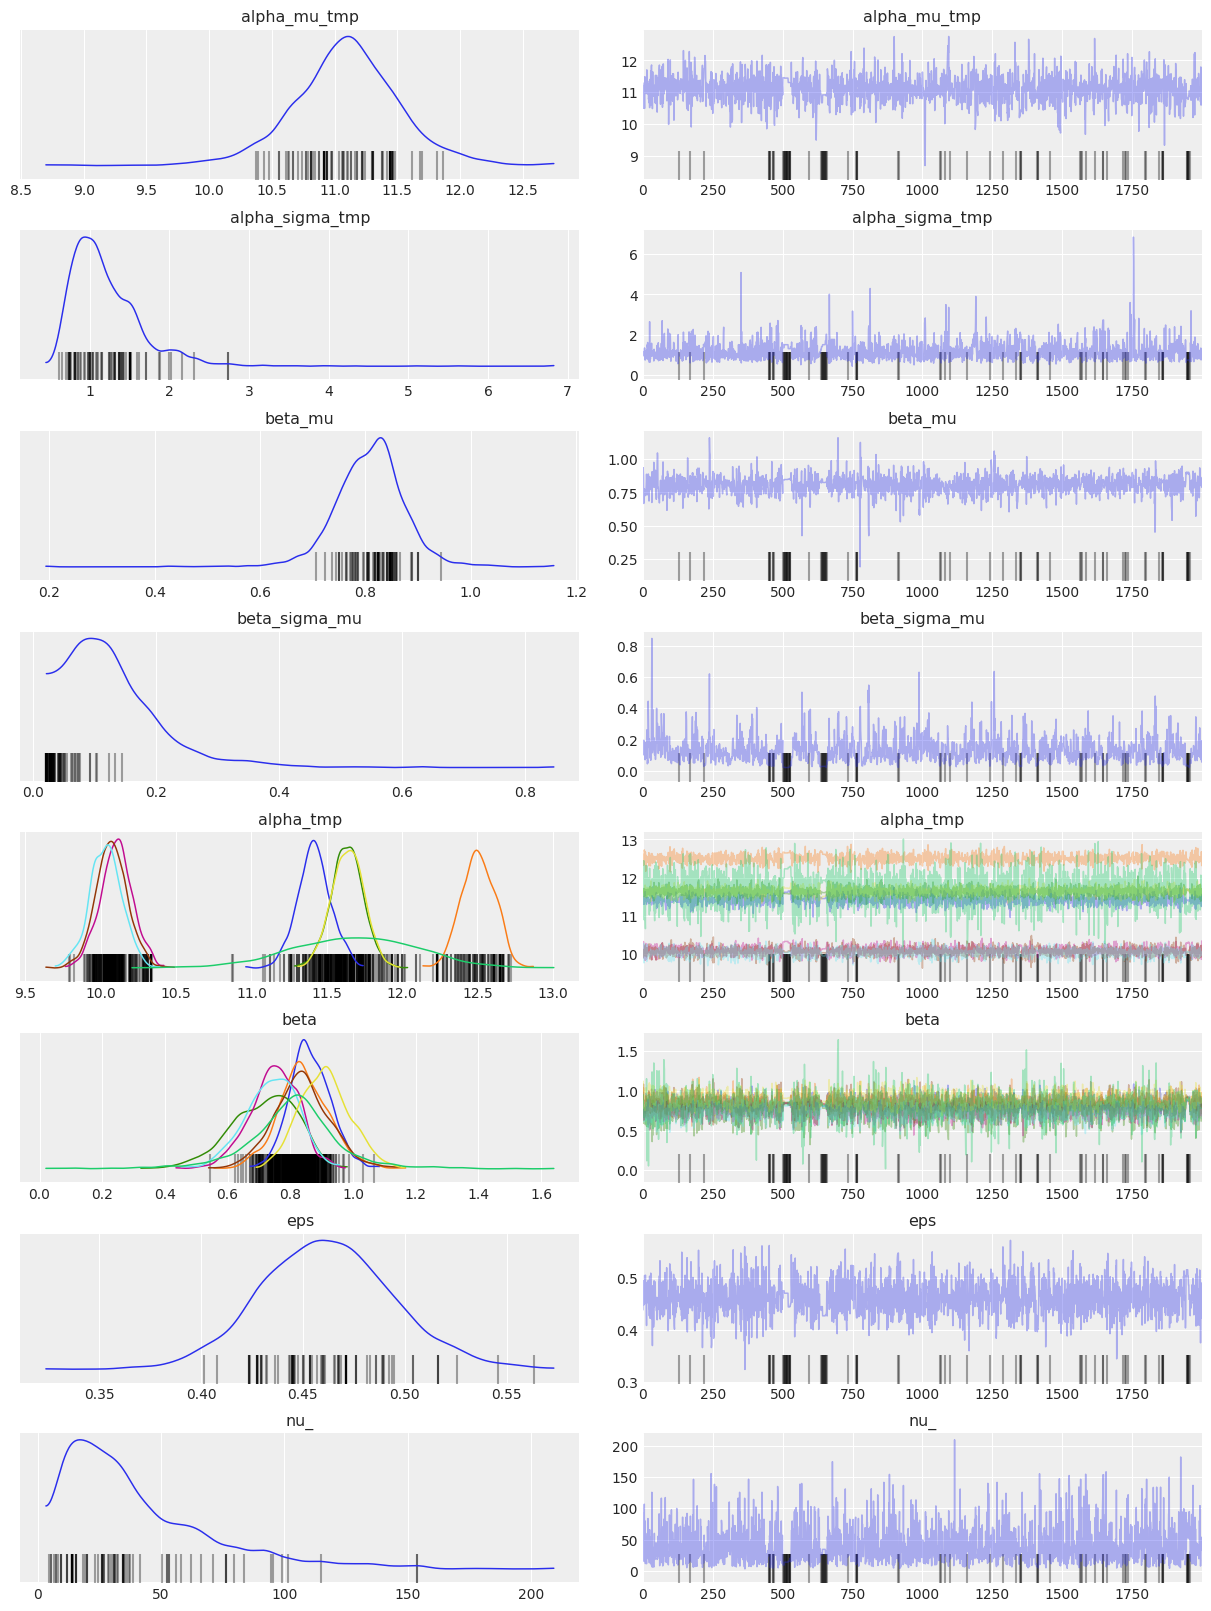

In [368]:
az.plot_trace(pyro_data, compact=True);

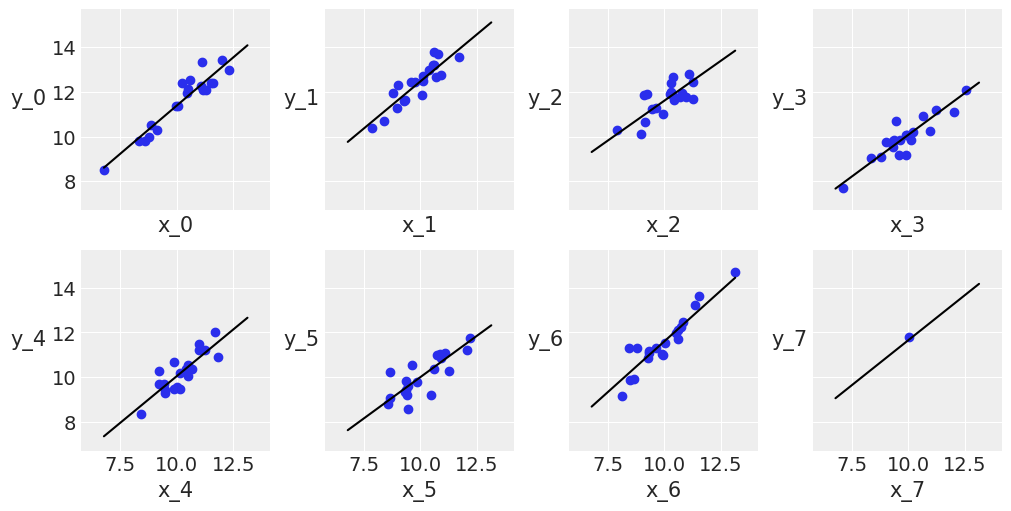

In [369]:
_, ax = plt.subplots(2, 4, figsize=(10, 5), sharex=True, sharey=True,
                     constrained_layout=True)
ax = np.ravel(ax)
j, k = 0, N
x_range = np.linspace(x_m.min(), x_m.max(), 10)
for i in range(M):
    ax[i].scatter(x_m[j:k], y_m[j:k])
    ax[i].set_xlabel(f'x_{i}')
    ax[i].set_ylabel(f'y_{i}', labelpad=17, rotation=0)
    # 
    alpha_m = posterior_predictive['alpha'][:, idx==i].mean()
    beta_m = posterior_samples['beta'][:, i].mean()
    
#     alpha_m = trace_hm['α'][:, i].mean()
#     beta_m = trace_hm['β'][:, i].mean()
    ax[i].plot(x_range, alpha_m + beta_m * x_range, c='k',
               label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')
    plt.xlim(x_m.min()-1, x_m.max()+1)
    plt.ylim(y_m.min()-1, y_m.max()+1)
    j += N
    k += N
# plt.savefig('B11197_03_17.png', dpi=300)

## Polynomial regression

In [ ]:
x_2 = ans[ans.group == 'II']['x'].values
y_2 = ans[ans.group == 'II']['y'].values
x_2 = x_2 - x_2.mean()

plt.scatter(x_2, y_2)
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.savefig('B11197_03_18.png', dpi=300)

In [ ]:
with pm.Model() as model_poly:
    alpha = pm.Normal('alpha', mu=y_2.mean(), sd=1)
    beta1 = pm.Normal('beta1', mu=0, sd=1)
    beta2 = pm.Normal('beta2', mu=0, sd=1)
    eps = pm.HalfCauchy('eps', 5)

    mu = alpha + beta1 * x_2 + beta2 * x_2**2

    y_pred = pm.Normal('y_pred', mu=mu, sd=eps, observed=y_2)

    trace_poly = pm.sample(2000)

In [ ]:
#az.plot_trace(trace_poly);

In [ ]:
#az.summary(trace_poly)

In [ ]:
x_p = np.linspace(-6, 6)
y_p = trace_poly['alpha'].mean() + trace_poly['beta1'].mean() * \
    x_p + trace_poly['beta2'].mean() * x_p**2
plt.scatter(x_2, y_2)
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.plot(x_p, y_p, c='C1')
plt.savefig('B11197_03_19.png', dpi=300)

## Multiple Linear regression

In [ ]:
np.random.seed(314)
N = 100
alpha_real = 2.5
beta_real = [0.9, 1.5]
eps_real = np.random.normal(0, 0.5, size=N)

X = np.array([np.random.normal(i, j, N) for i, j in zip([10, 2], [1, 1.5])]).T
X_mean = X.mean(axis=0, keepdims=True)
X_centered = X - X_mean
y = alpha_real + np.dot(X, beta_real) + eps_real

In [ ]:
def scatter_plot(x, y):
    plt.figure(figsize=(10, 10))
    for idx, x_i in enumerate(x.T):
        plt.subplot(2, 2, idx+1)
        plt.scatter(x_i, y)
        plt.xlabel(f'x_{idx+1}')
        plt.ylabel(f'y', rotation=0)

    plt.subplot(2, 2, idx+2)
    plt.scatter(x[:, 0], x[:, 1])
    plt.xlabel(f'x_{idx}')
    plt.ylabel(f'x_{idx+1}', rotation=0)

scatter_plot(X_centered, y)
plt.savefig('B11197_03_20.png', dpi=300)

In [ ]:
with pm.Model() as model_mlr:
    alpha_tmp = pm.Normal('alpha_tmp', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1, shape=2)
    eps = pm.HalfCauchy('eps', 5)

    mu = alpha_tmp + pm.math.dot(X_centered, beta)

    alpha = pm.Deterministic('alpha', alpha_tmp - pm.math.dot(X_mean, beta))

    y_pred = pm.Normal('y_pred', mu=mu, sd=eps, observed=y)

    trace_mlr = pm.sample(2000)

In [ ]:
varnames = ['alpha', 'beta', 'eps']
#az.plot_trace(trace_mlr, var_names=varnames);

In [ ]:
az.summary(trace_mlr, var_names=varnames)

## Confounding variables and redundant variables

In [ ]:
np.random.seed(42)
N = 100
x_1 = np.random.normal(size=N)
x_2 = x_1 + np.random.normal(size=N, scale=1)
#x_2 = x_1 + np.random.normal(size=N, scale=0.01)
y = x_1 + np.random.normal(size=N)
X = np.vstack((x_1, x_2)).T

In [ ]:
scatter_plot(X, y)
plt.savefig('B11197_03_21.png', dpi=300)

In [ ]:
with pm.Model() as m_x1x2:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta1 = pm.Normal('beta1', mu=0, sd=10)
    beta2 = pm.Normal('beta2', mu=0, sd=10)
    eps = pm.HalfCauchy('eps', 5)

    mu = alpha + beta1 * X[:, 0] + beta2 * X[:, 1]

    y_pred = pm.Normal('y_pred', mu=mu, sd=eps, observed=y)

    trace_x1x2 = pm.sample(2000)


with pm.Model() as m_x1:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta1 = pm.Normal('beta1', mu=0, sd=10)
    eps = pm.HalfCauchy('eps', 5)

    mu = alpha + beta1 * X[:, 0]

    y_pred = pm.Normal('y_pred', mu=mu, sd=eps, observed=y)

    trace_x1 = pm.sample(2000)

with pm.Model() as m_x2:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta2 = pm.Normal('beta2', mu=0, sd=10)
    eps = pm.HalfCauchy('eps', 5)

    mu = alpha + beta2 * X[:, 1]

    y_pred = pm.Normal('y_pred', mu=mu, sd=eps, observed=y)

    trace_x2 = pm.sample(2000)

In [ ]:
az.plot_forest([trace_x1x2, trace_x1, trace_x2],
               model_names=['m_x1x2', 'm_x1', 'm_x2'],
               var_names=['beta1', 'beta2'],
               combined=False, colors='cycle', figsize=(8, 3))
plt.savefig('B11197_03_22.png', dpi=300)

In [ ]:
# just repeating the code from a couple of cells before, but with a lower value of `scale`.
np.random.seed(42)
N = 100
x_1 = np.random.normal(size=N)
x_2 = x_1 + np.random.normal(size=N, scale=0.01)
y = x_1 + np.random.normal(size=N)
X = np.vstack((x_1, x_2)).T

In [ ]:
scatter_plot(X, y)
plt.savefig('B11197_03_23.png', dpi=300)

In [ ]:
with pm.Model() as model_red:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10, shape=2)
    eps = pm.HalfCauchy('eps', 5)

    mu = alpha + pm.math.dot(X, beta)

    y_pred = pm.Normal('y_pred', mu=mu, sd=eps, observed=y)

    trace_red = pm.sample(2000)

In [ ]:
az.plot_forest(trace_red, var_names=['beta'], combined=True, figsize=(8, 2))
plt.savefig('B11197_03_24.png', dpi=300)

In [ ]:
az.plot_pair(trace_red, var_names=['beta'])
plt.savefig('B11197_03_25.png', dpi=300)

## Masking effect variables

In [ ]:
np.random.seed(42)
N = 126
r = 0.8
x_1 = np.random.normal(size=N)
x_2 = np.random.normal(x_1, scale=(1 - r ** 2) ** 0.5)
y = np.random.normal(x_1 - x_2)
X = np.vstack((x_1, x_2)).T

In [ ]:
scatter_plot(X, y)
plt.savefig('B11197_03_26.png', dpi=300, figsize=(5.5, 5.5))

In [ ]:
with pm.Model() as m_x1x2:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta1 = pm.Normal('beta1', mu=0, sd=10)
    beta2 = pm.Normal('beta2', mu=0, sd=10)
    eps = pm.HalfCauchy('eps', 5)

    mu = alpha + beta1 * X[:, 0] + beta2 * X[:, 1]

    y_pred = pm.Normal('y_pred', mu=mu, sd=eps, observed=y)

    trace_x1x2 = pm.sample(1000)


with pm.Model() as m_x1:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta1 = pm.Normal('beta1', mu=0, sd=10)
    eps = pm.HalfCauchy('eps', 5)

    mu = alpha + beta1 * X[:, 0]

    y_pred = pm.Normal('y_pred', mu=mu, sd=eps, observed=y)

    trace_x1 = pm.sample(1000)

with pm.Model() as m_x2:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta2 = pm.Normal('beta2', mu=0, sd=10)
    eps = pm.HalfCauchy('eps', 5)

    mu = alpha + beta2 * X[:, 1]

    y_pred = pm.Normal('y_pred', mu=mu, sd=eps, observed=y)

    trace_x2 = pm.sample(1000)

In [ ]:
az.plot_forest([trace_x1x2, trace_x1, trace_x2],
               model_names=['m_x1x2', 'm_x1', 'm_x2'],
               var_names=['beta1', 'beta2'],
               combined=True, colors='cycle', figsize=(8, 3))
plt.savefig('B11197_03_27.png', dpi=300, bbox_inches='tight')

## Variable variance

In [ ]:
data = pd.read_csv('../data/babies.csv')
data.plot.scatter('Month', 'Lenght')
plt.savefig('B11197_03_28.png', dpi=300)

In [ ]:
with pm.Model() as model_vv:
    alpha = pm.Normal('alpha', sd=10)
    beta = pm.Normal('beta', sd=10)
    γ = pm.HalfNormal('γ', sd=10)
    δ = pm.HalfNormal('δ', sd=10)

    x_shared = shared(data.Month.values * 1.)

    mu = pm.Deterministic('mu', alpha + beta * x_shared**0.5)
    eps = pm.Deterministic('eps', γ + δ * x_shared)

    y_pred = pm.Normal('y_pred', mu=mu, sd=eps, observed=data.Lenght)

    trace_vv = pm.sample(1000, tune=1000)

In [ ]:
plt.plot(data.Month, data.Lenght, 'C0.', alpha=0.1)

mu_m = trace_vv['mu'].mean(0)
eps_m = trace_vv['eps'].mean(0)

plt.plot(data.Month, mu_m, c='k')
plt.fill_between(data.Month, mu_m + 1 * eps_m, mu_m -
                 1 * eps_m, alpha=0.6, color='C1')
plt.fill_between(data.Month, mu_m + 2 * eps_m, mu_m -
                 2 * eps_m, alpha=0.4, color='C1')

plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.savefig('B11197_03_29.png', dpi=300)

In [ ]:
x_shared.set_value([0.5])
ppc = pm.sample_posterior_predictive(trace_vv, 2000, model=model_vv)
y_ppc = ppc['y_pred'][:, 0]

In [ ]:
ref = 53
density, l, u = az._fast_kde(y_ppc)
x_ = np.linspace(l, u, 200)
plt.plot(x_, density)
percentile = int(sum(y_ppc <= ref) / len(y_ppc) * 100)
plt.fill_between(x_[x_ < ref], density[x_ < ref],
                 label='percentile = {:2d}'.format(percentile))
plt.xlabel('length')
plt.yticks([])
plt.legend()
plt.savefig('B11197_03_30.png', dpi=300)

In [ ]:
x_4 = ans[ans.group == 'IV']['x'].values
y_4 = ans[ans.group == 'IV']['y'].values

with pm.Model() as model_t2:
    alpha = pm.Normal('alpha', mu=0, sd=100)
    beta = pm.Normal('beta', mu=0, sd=1)
    eps = pm.HalfCauchy('eps', 5)
    ν = pm.Exponential('ν', 1/30)
    #ν = pm.Gamma('ν', mu=20, sd=15)
    #ν = pm.Gamma('ν', 2, 0.1)

    y_pred = pm.StudentT('y_pred', mu=alpha + beta * x_4, sd=eps, nu=ν, observed=y_4)
    trace_t2 = pm.sample(2000)